### Create bottleneck features

In [1]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from tqdm import tqdm
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

modelTransfer = ResNet50(weights='imagenet', include_top=False)

ModuleNotFoundError: No module named 'keras'

In [2]:
#modelTransfer.summary()
#modelTransfer.layers[141]

In [3]:
from keras.models import Model

#inputs = modelTransfer.inputs
#outputs = modelTransfer.layers[121].output
#modelTransfer = Model(inputs=inputs, outputs=outputs)

In [4]:
from matplotlib.pyplot import imshow

ratio = 0.664179104477612
target_width = 224
target_size = (target_width, round(target_width/ratio))

datagen_train = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    #zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

def path_to_bottleneck_feature(img_path, argument=0):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=target_size)
   
    # convert PIL.Image.Image type to 3D tensor
    x = image.img_to_array(img)
     
    # convert 3D tensor to 4D tensor with shape (1, ?, ?, 3) and return 4D tensor
    x = np.expand_dims(x, axis=0)
    
    # preprocess input
    x = preprocess_input(x)
    
    if argument > 0:
        ite = datagen_train.flow(x, [0])
        argumented = [ite.next()[0] for i in range(argument)]
        argumented.append(x)
        argumented = np.vstack(argumented)
        return modelTransfer.predict(argumented)

    # prediction applied to one image at time to save memory (a batch imaplementation would have been more optimal)
    return modelTransfer.predict(x)

def paths_to_bottleneck_features(img_paths, argument=0):
    bottleneck_features = []
    paths = []
    for img_path in tqdm(img_paths):
        try:
            bottleneck_features.append(path_to_bottleneck_feature(img_path, argument))
            paths.append(img_path)
        except OSError:
            None 
            
    return paths, np.vstack(bottleneck_features)

In [6]:
#print(len(glob.glob("data/valid/melanoma/*.jpg")))
#print(len(glob.glob("data/valid/nevus/*.jpg")))
#print(len(glob.glob("data/valid/seborrheic_keratosis/*.jpg")))

In [9]:
import glob
import pickle

datasets = ['test', 'train', 'valid']
diagnoses = ['melanoma', 'nevus', 'seborrheic_keratosis']
diagnose_to_index = {diagnoses[i]: i for i in range(len(diagnoses))}

def get_bottleneck_feature(dataset, argument=[0,0,0]):
    features = []
    labels = []
    img_paths = []
    index = 0
    for diagnose in diagnoses:
        path = "data/{}/{}/*.jpg".format(dataset, diagnose)
        paths = glob.glob(path)

        paths, paths_features = paths_to_bottleneck_features(paths, argument[index])
        index = index + 1
        paths_labels = np.full(len(paths_features), diagnose_to_index[diagnose])
        
        features = paths_features if len(features) == 0 else np.concatenate([features, paths_features])
        labels = paths_labels if len(labels) == 0 else np.concatenate([labels, paths_labels])
        img_paths = paths if len(img_paths) == 0 else np.concatenate([img_paths, paths])

    return features, labels, img_paths



train_x, train_y, _ = get_bottleneck_feature('train', [2,0,4])
valid_x, valid_y, _ = get_bottleneck_feature('valid')
test_x, test_y, test_paths = get_bottleneck_feature('test')


bottleneck_feature = {
    'test_x': test_x,
    'test_y': test_y,
    'test_paths': test_paths,
    'train_x': train_x,
    'train_y': train_y,
    'valid_x': valid_x,
    'valid_y': valid_y
}

with open('models/bottleneck_feature.pickle', 'wb') as f:
    pickle.dump(bottleneck_feature, f, pickle.HIGHEST_PROTOCOL)

100%|██████████| 90/90 [00:12<00:00,  6.93it/s]


In [62]:
from keras.utils import to_categorical
import pickle

with open('models/bottleneck_feature.pickle', 'rb') as f:
    bottleneck_feature = pickle.load(f)
    
train_x = bottleneck_feature['train_x']
train_y = to_categorical(bottleneck_feature['train_y'], 3)

valid_x = bottleneck_feature['valid_x']
valid_y = to_categorical(bottleneck_feature['valid_y'], 3)

test_x = bottleneck_feature['test_x']
test_y = to_categorical(bottleneck_feature['test_y'], 3)
test_paths = bottleneck_feature['test_paths']

print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)
print(test_x.shape)
print(test_y.shape)

(3764, 1, 1, 2048)
(3764, 3)
(150, 1, 1, 2048)
(150, 3)
(600, 1, 1, 2048)
(600, 3)


In [330]:
from keras.layers import GlobalAveragePooling2D, Flatten, Conv2D
from keras.layers import Dropout, Dense, BatchNormalization
from keras.models import Sequential
from keras.initializers import TruncatedNormal
from keras.regularizers import l1, l2

model = Sequential()

#model.add(Conv2D(1012, 3, 3, border_mode='same', input_shape=train_x.shape[1:]))
#model.add(BatchNormalization())
#model.add(Conv2D(2024, 3, 3, border_mode='same'))
#model.add(GlobalAveragePooling2D())
model.add(Flatten(input_shape=train_x.shape[1:]))
#model.add(BatchNormalization(input_shape=train_x.shape[1:]))
#model.add(GlobalAveragePooling2D(input_shape=train_x.shape[1:]))
#model.add(Dropout(0.3))
#model.add(BatchNormalization())
#model.add(Dense(2048, activation='relu', kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.0001, seed=None)))
#model.add(Dense(2048, activation='relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Dense(3060, activation='relu', kernel_regularizer=l2(0.03)))
#model.add(BatchNormalization())
model.add(Dense(3060, activation='relu', kernel_regularizer=l2(0.02)))
#model.add(BatchNormalization())
#model.add(Dense(2048, activation='relu', kernel_regularizer=l2(0.05)))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
#model.add(Dense(2048, activation='relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_57 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_169 (Dense)            (None, 3060)              6269940   
_________________________________________________________________
dense_170 (Dense)            (None, 3060)              9366660   
_________________________________________________________________
dense_171 (Dense)            (None, 3)                 9183      
Total params: 15,645,783
Trainable params: 15,645,783
Non-trainable params: 0
_________________________________________________________________


In [331]:
from keras.optimizers import Adam, RMSprop, SGD
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.005, amsgrad=False)
#optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.005)
#optimizer = SGD(lr=0.001, decay=0.00, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [332]:
from keras.callbacks import ModelCheckpoint 

checkpointer = ModelCheckpoint(filepath='models/weights.best.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_x, train_y, 
          validation_data=(valid_x, valid_y),
          epochs=30, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 3764 samples, validate on 150 samples
Epoch 1/30
3764/3764 [==============================] - 5s 1ms/step - loss: 14.4958 - acc: 0.6751 - val_loss: 1.5924 - val_acc: 0.5933

Epoch 00001: val_loss improved from inf to 1.59241, saving model to models/weights.best.hdf5
Epoch 2/30
3764/3764 [==============================] - 2s 604us/step - loss: 0.9408 - acc: 0.7723 - val_loss: 0.9941 - val_acc: 0.6867

Epoch 00002: val_loss improved from 1.59241 to 0.99407, saving model to models/weights.best.hdf5
Epoch 3/30
3764/3764 [==============================] - 2s 596us/step - loss: 0.6852 - acc: 0.7962 - val_loss: 0.9637 - val_acc: 0.6200

Epoch 00003: val_loss improved from 0.99407 to 0.96368, saving model to models/weights.best.hdf5
Epoch 4/30
3764/3764 [==============================] - 2s 600us/step - loss: 0.5966 - acc: 0.8156 - val_loss: 0.8792 - val_acc: 0.6800

Epoch 00004: val_loss improved from 0.96368 to 0.87919, saving model to models/weights.best.hdf5
Epoch 5/30
3764/3764 [

In [333]:
model.save_weights('models/weights.hdf5')

In [334]:
import numpy as np

model.load_weights('models/weights.hdf5')

predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_x]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_y, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 73.5000%


In [335]:
import csv

pred = model.predict(test_x)
with open('sample_submission.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Id','task_1','task_2'])
    for i in range(len(pred)): 
        writer.writerow([test_paths[i], pred[i,0], pred[i,2]])

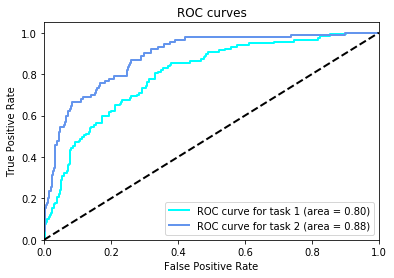

Category 1 Score: 0.798
Category 2 Score: 0.885
Category 3 Score: 0.842


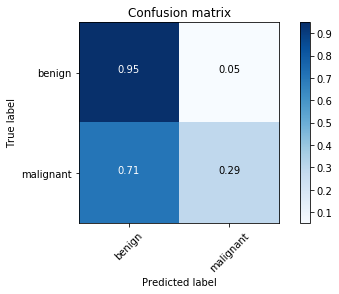

In [336]:
from get_results import plot_roc_auc, plot_confusion_matrix

thresh = 0.5
    
# get ground truth labels for test dataset
truth = pd.read_csv('ground_truth.csv')
y_true = truth.as_matrix(columns=["task_1", "task_2"])

# get model predictions for test dataset
y_pred = pd.read_csv('sample_submission.csv')
y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])

# plot ROC curves and print scores
plot_roc_auc(y_true, y_pred)
# plot confusion matrix
classes = ['benign', 'malignant']
plot_confusion_matrix(y_true[:,0], y_pred[:,0], thresh, classes)